In [161]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt
from itertools import permutations

In [162]:
df = pd.read_csv('/content/drive/MyDrive/TSPDATA.txt', sep=",", header=None)

size = 30

df = df[:size]

x = df[0]
y = df[1]

# 1. Initialization

## a. Calculate the Euclidean distance between every two cities and store them in matrix dist of size n*n, where n is the number of nodes (i.e., cities) in your network.
## b. Create a matrix eta which store the reciprocal of the distances, where eta(i,j) = 1/dist(i,j).


In [163]:
def initialize_data(df):
    x = df[0]
    y = df[1]
    n = len(x)
    dist = np.full((n, n), 1000000, dtype='float64')
    eta =np.full((n, n), 1000000, dtype='float64')

    for i in range (n):
      for j in range(n):
        if (i != j):
          dist[i][j]=math.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
          eta[i][j] = 1 / dist[i][j]
            
    return dist, eta


## c. Calculate the tour length using nearest neighbor heuristic Lnn from a randomly chosen initial node (i.e. start at any city and move from city to city by finding the one that is closest to you until you finish completing the tour).

In [164]:
def nearest_neighbor_tour(df, dist):
    n = len(df)
    start_city = np.random.randint(0,n-1)
    unvisited = set(range(1, n))
    tour = [start_city]
    
    while unvisited:
        current_city = tour[-1]
        next_city = min(unvisited, key=lambda city: dist[current_city, city])
        tour.append(next_city)
        unvisited.remove(next_city)
        
    tour.append(start_city)
    
    tour_length = np.sum(dist[tour[i], tour[i+1]] for i in range(n))
    
    return tour_length

## d. Set tau_0 = 1/(n*Lnn).
## e. Create an n*n matrix of pheromones and set tau(i,j) = tau_0

In [165]:
def initialize_pheromones(df, Lnn):
    n = len(df)
    tau_0 = 1/(n * Lnn)
    tau = np.full((n, n), tau_0)
    return tau

# 2. While ants have not constructed a complete tour, for each ant, apply the state transition rule to find the next city to visit.

In [166]:
def state_transition_rule(current_city, unvisited, tau, eta, alpha, beta):
    probabilities = [tau[current_city, city]**alpha * eta[current_city, city]**beta for city in unvisited]
    total_probability = np.sum(probabilities)
    probabilities = [p/total_probability for p in probabilities]
    next_city = np.random.choice(list(unvisited), p=probabilities)
    return next_city

# TOUR CONSTRUCTION

In [167]:
def construct_tour(ant, df, tau, eta, alpha, beta):
    n = len(df)

    if ant >= n:
      temp = ant / n
      ant -= n * int(temp)

    start_city = ant
    unvisited = set(range(n)) - {start_city}
    tour = [start_city]
    
    while unvisited:
        current_city = tour[-1]
        next_city = state_transition_rule(current_city, unvisited, tau, eta, alpha, beta)
        tour.append(next_city)
        unvisited.remove(next_city)
        
    tour.append(start_city)
    
    return tour

# 3. When each ant has constructed a complete tour, remove the cycles in the tour (i.e., generate acyclic tours).


In [168]:
def remove_cycles(tour):
    visited = set()
    new_tour = []

    for city in tour:
        if city not in visited:
            new_tour.append(city)
            visited.add(city)
            
    new_tour.append(new_tour[0])
    return new_tour

#  4. Based on the (acyclic) tours constructed by the ants, apply pheromone update rules to update the pheromones matrix tau. 

In [169]:
def update_pheromones(tau, tours, dist, rho):
    n = len(tau)
    delta_tau = np.zeros((n, n))

    for tour in tours:
        tour_len = len(tour)
        for i in range(tour_len - 1):
            a, b = tour[i], tour[i+1]
            delta_tau[a, b] += 1/dist[a, b]
            delta_tau[b, a] += 1/dist[a, b]
            
    tau = (1 - rho) * tau + delta_tau
    return tau

# MAIN FUNCTION (i.e. Repeat steps 2 to 4 for the desired number of iterations)

In [170]:
def ant_colony_system(df, m, alpha, beta, rho, iterations):
    dist, eta = initialize_data(df)
    Lnn = nearest_neighbor_tour(df, dist)
    tau = initialize_pheromones(df, Lnn)
    
    n = len(df)
    ants = list(range(m - 1))
    
    best_tours = {i: ([], float('inf')) for i in range(n)}
    best_tours_lengths = [100000] * n

    for _ in range(iterations):
        tours = []
        for ant in ants:
            tour = construct_tour(ant, df, tau, eta, alpha, beta)
            tour = remove_cycles(tour)
            tours.append(tour)
            
            tour_length = np.sum(dist[tour[i], tour[i+1]] for i in range(len(tour) - 1))
            if ant >= n:
              temp = ant / n
              ant -= n * int(temp)
            if tour_length < best_tours_lengths[ant]:
                best_tours[ant] = tour
                best_tours_lengths[ant] = tour_length

        tau = update_pheromones(tau, tours, dist, rho)
        
    return best_tours, best_tours_lengths

## TESTING:

In [171]:
m = int(input("Number of ants: "))
iterations = int(input("Number of Iterations: "))
alpha = float(input("Alpha value: "))
beta = float(input("Beta value: "))
rho = float(input("Rho value: "))

best_tours, best_tours_lengths = ant_colony_system(df, m, alpha, beta, rho, iterations)

n = len(df)
j=0
s = 0

for i in range(n):
  print(f'''
  >CITY {i}:
  -Initial Position: ({x[i]}, {y[i]}) 
  -Best Tour: {best_tours[i]}
  -Length: {best_tours_lengths[i]}
  ''')
  if best_tours_lengths[i] != 100000:
    s += best_tours_lengths[i]
  j += 1

print(f'AVERAGE TOUR LENGTH USING {m} ANTS = {s / n}')


Number of ants: 300
Number of Iterations: 20
Alpha value: 1
Beta value: 2
Rho value: 0.5


<ipython-input-164-2a7eb4fb7ac3>:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  tour_length = np.sum(dist[tour[i], tour[i+1]] for i in range(n))
<ipython-input-170-76a3d1ce69a8>:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  tour_length = np.sum(dist[tour[i], tour[i+1]] for i in range(len(tour) - 1))



  >CITY 0:
  -Initial Position: (6.7, 2.1) 
  -Best Tour: [0, 21, 26, 12, 15, 23, 7, 8, 4, 16, 6, 10, 1, 24, 11, 9, 20, 17, 3, 27, 22, 18, 28, 13, 25, 2, 29, 5, 19, 14, 0]
  -Length: 44.91508731457599
  

  >CITY 1:
  -Initial Position: (0.2, 6.0) 
  -Best Tour: [1, 24, 11, 9, 17, 20, 3, 27, 22, 28, 13, 18, 25, 2, 29, 5, 19, 21, 0, 26, 12, 15, 23, 14, 7, 8, 4, 16, 6, 10, 1]
  -Length: 44.242036363655025
  

  >CITY 2:
  -Initial Position: (9.8, 4.5) 
  -Best Tour: [2, 25, 18, 28, 13, 22, 27, 3, 20, 17, 9, 11, 24, 1, 10, 6, 16, 4, 8, 7, 14, 23, 15, 12, 26, 0, 21, 19, 5, 29, 2]
  -Length: 44.10800109009709
  

  >CITY 3:
  -Initial Position: (6.2, 9.5) 
  -Best Tour: [3, 20, 17, 9, 11, 24, 1, 10, 6, 16, 4, 8, 7, 21, 0, 26, 12, 15, 23, 14, 19, 5, 29, 2, 25, 18, 28, 13, 22, 27, 3]
  -Length: 45.05641463752033
  

  >CITY 4:
  -Initial Position: (1.2, 0.6) 
  -Best Tour: [4, 16, 8, 7, 14, 23, 15, 12, 26, 0, 21, 19, 5, 29, 2, 25, 13, 28, 18, 22, 27, 3, 20, 17, 9, 11, 24, 1, 10, 6, 4]
  -Len

# Visualization

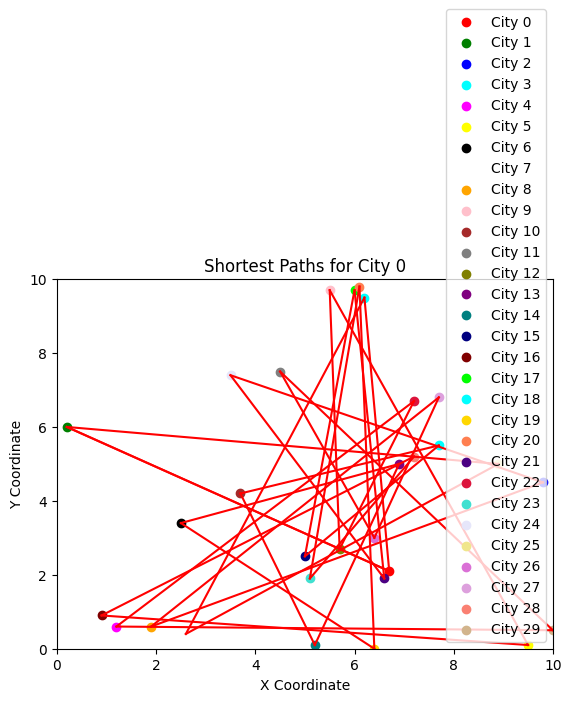

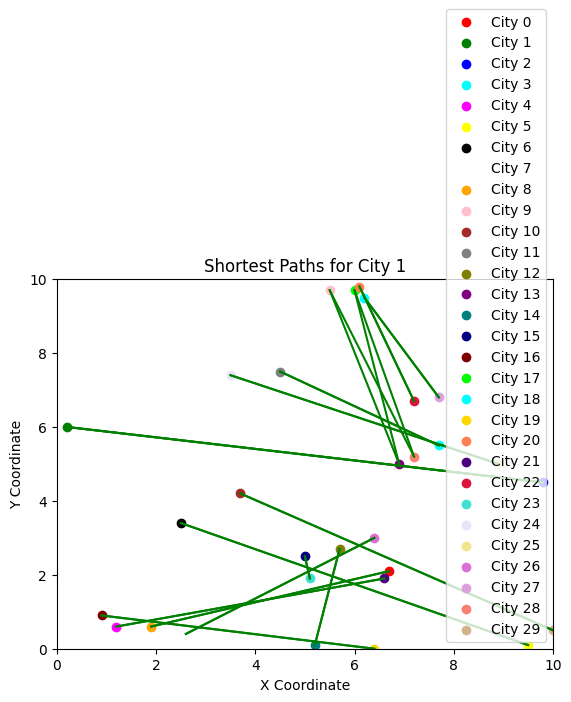

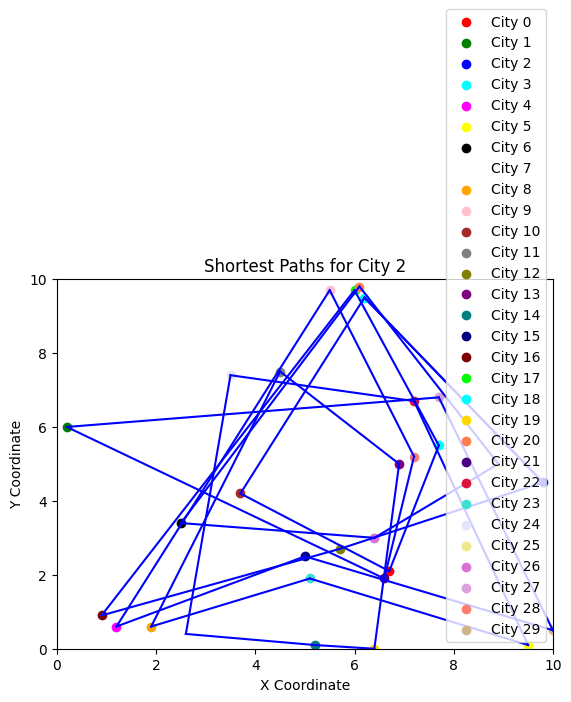

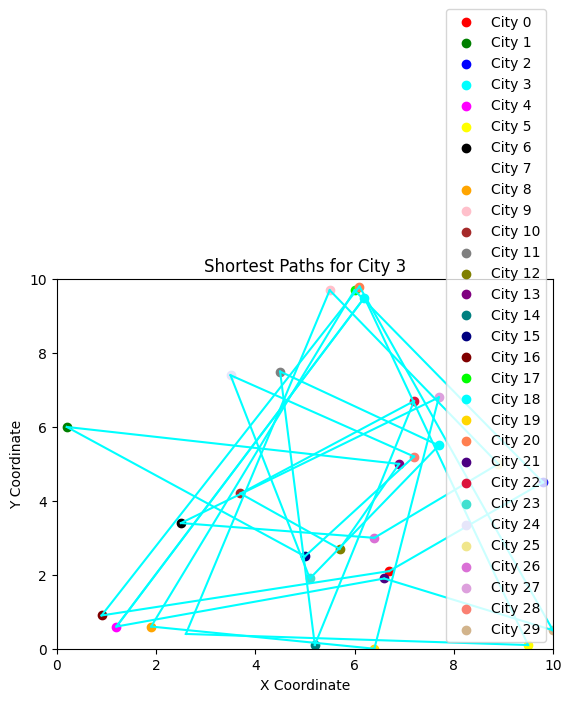

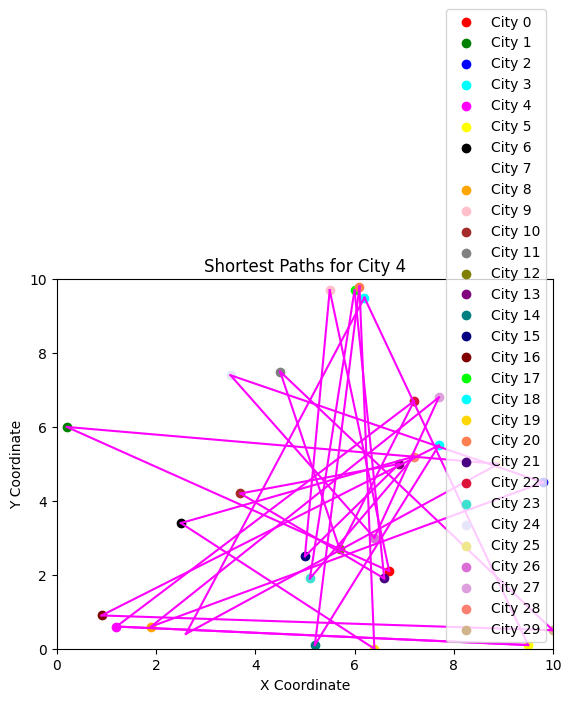

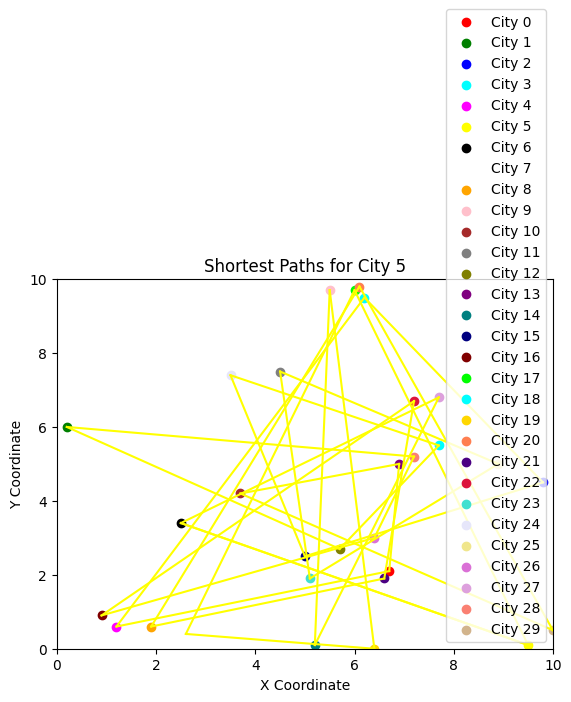

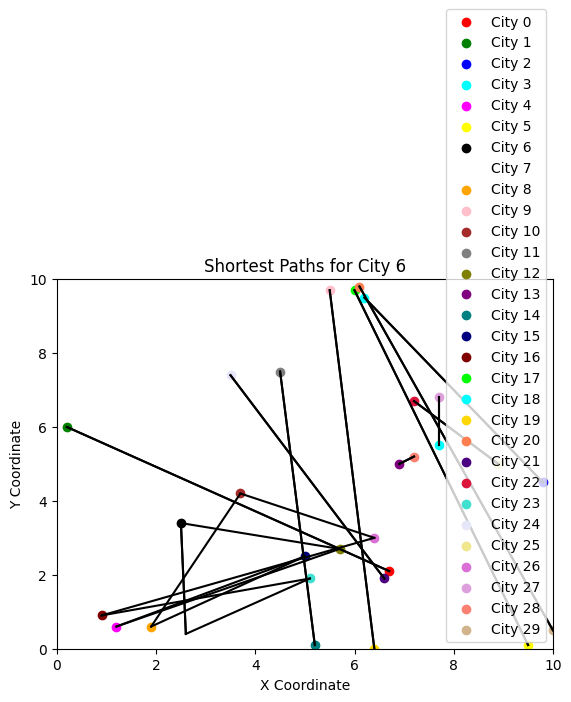

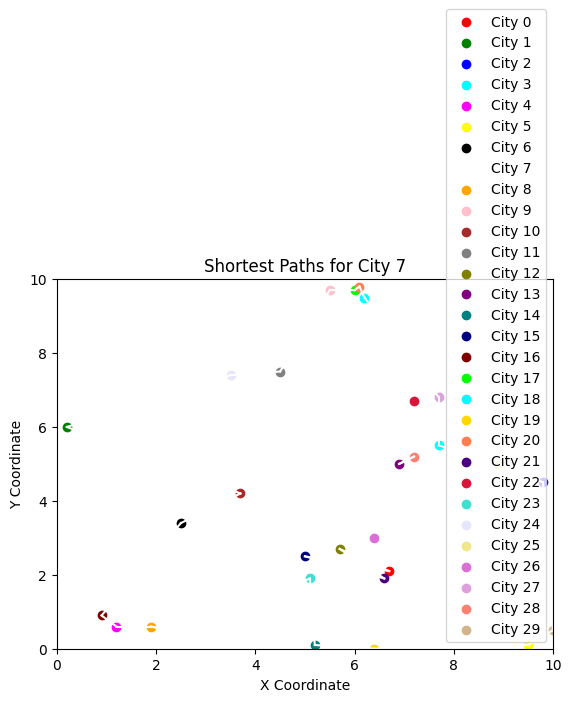

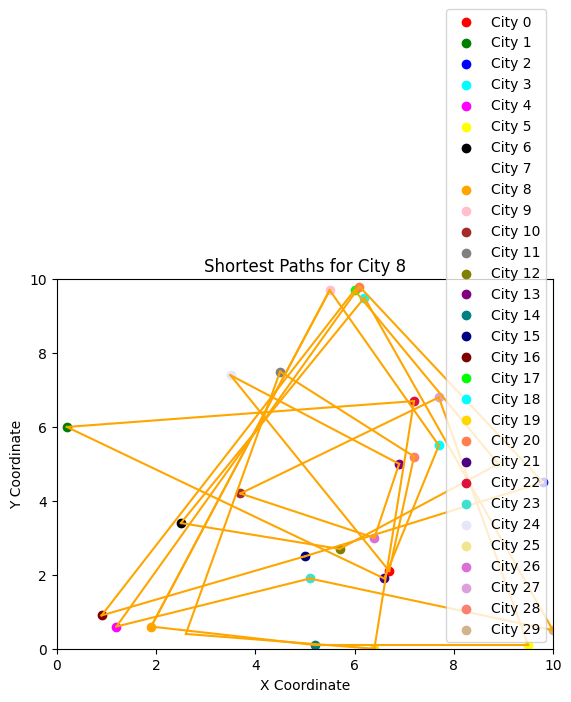

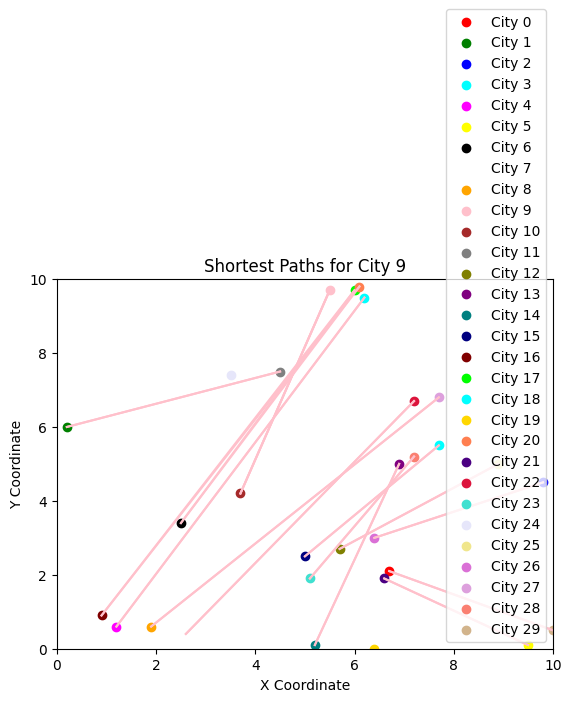

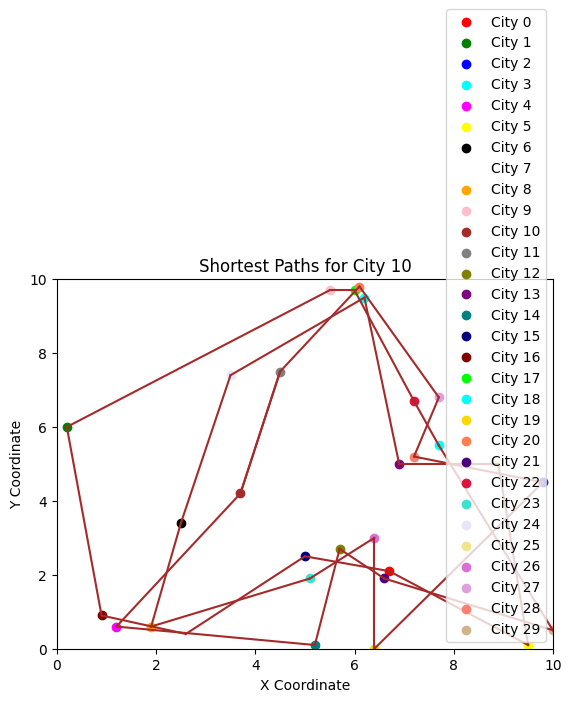

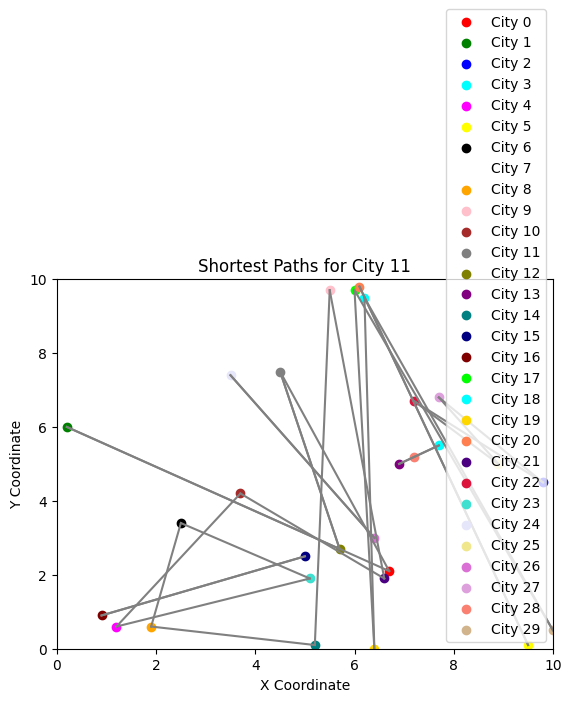

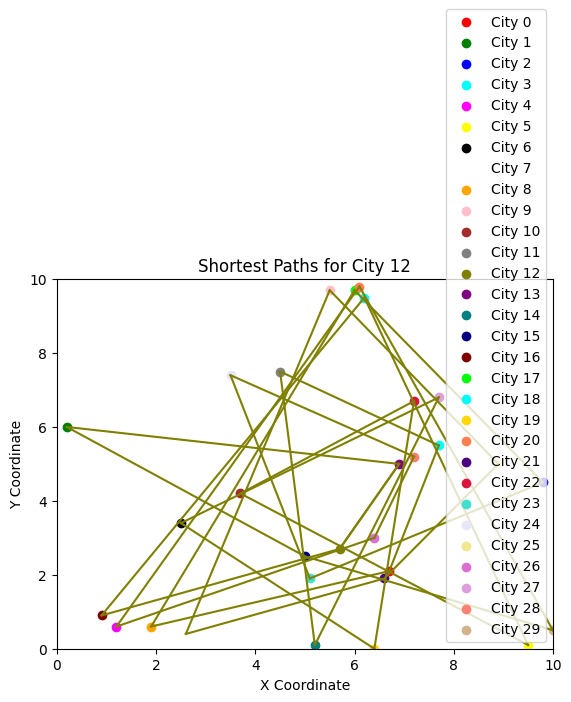

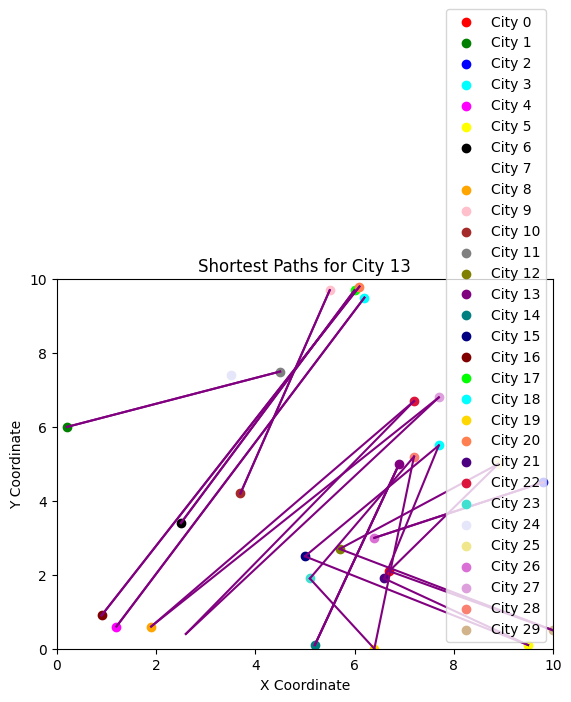

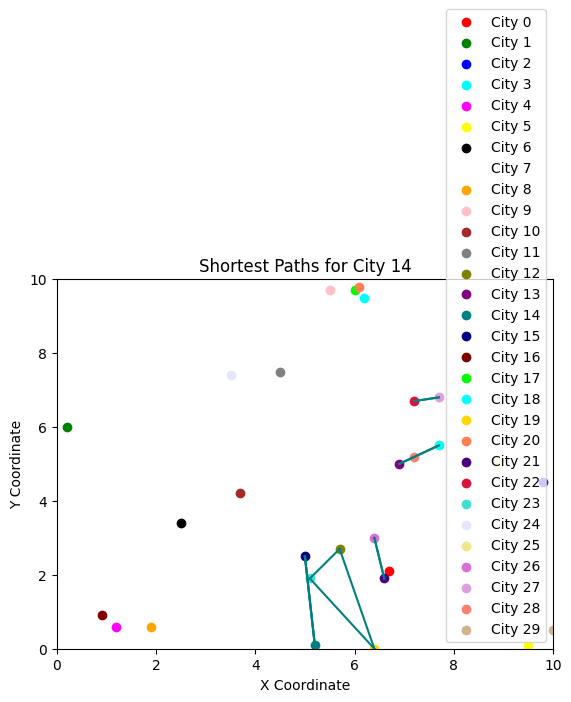

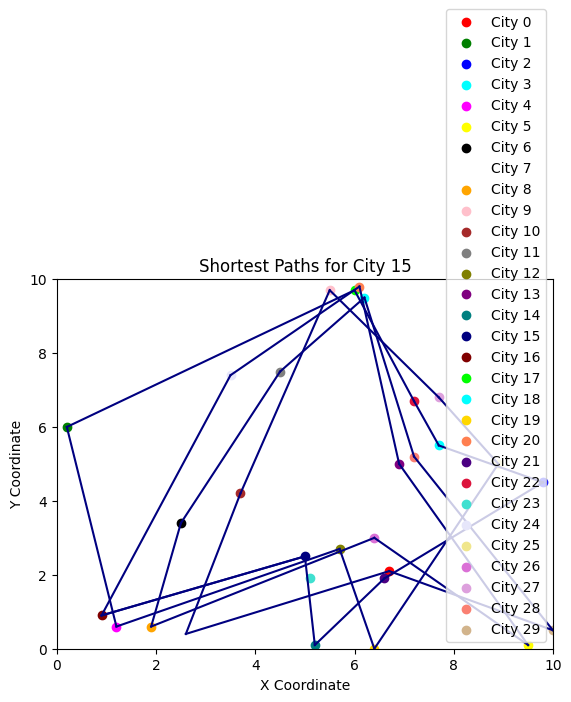

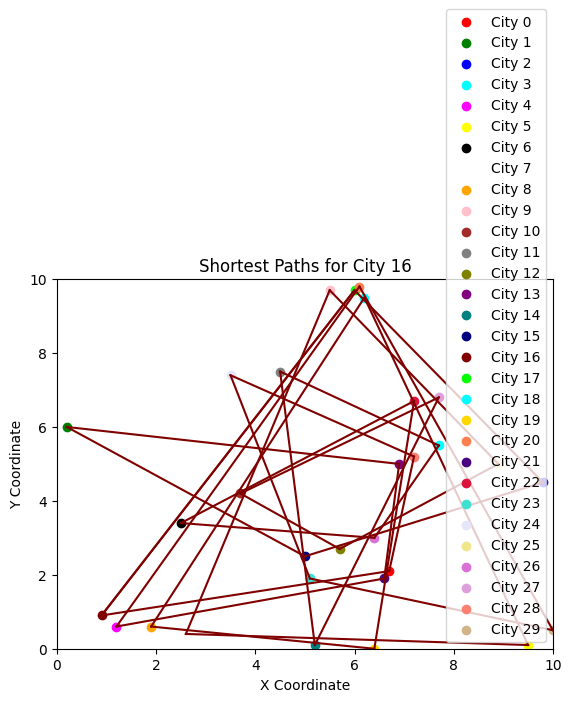

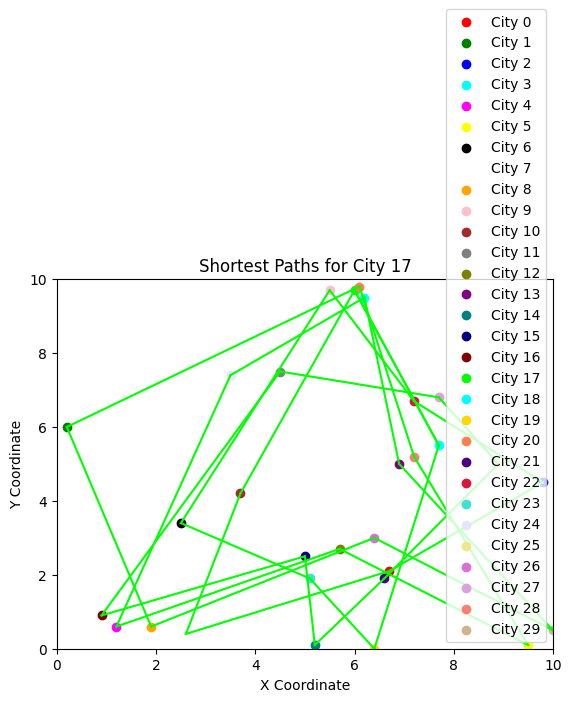

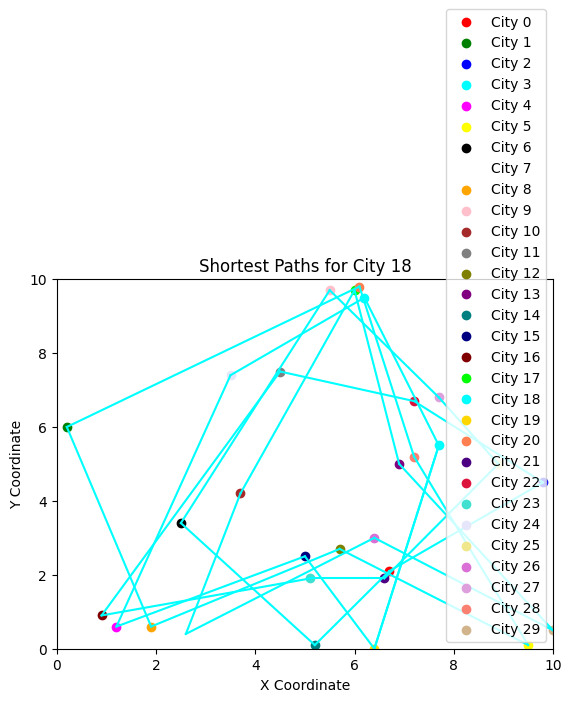

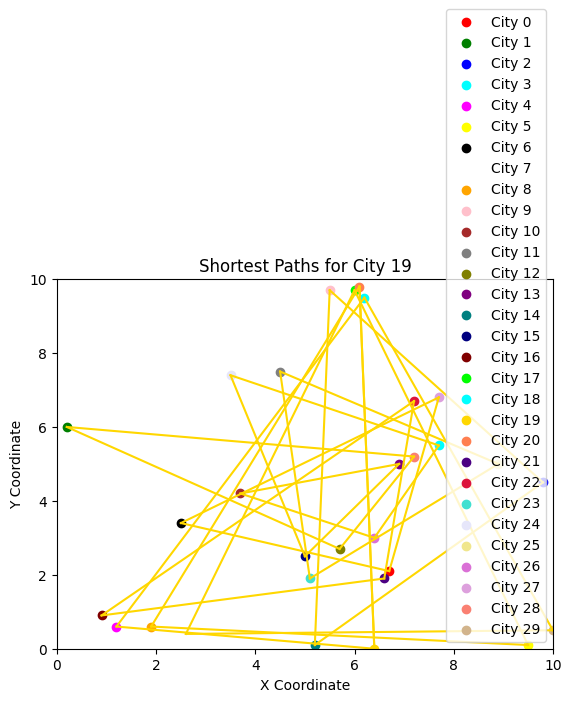

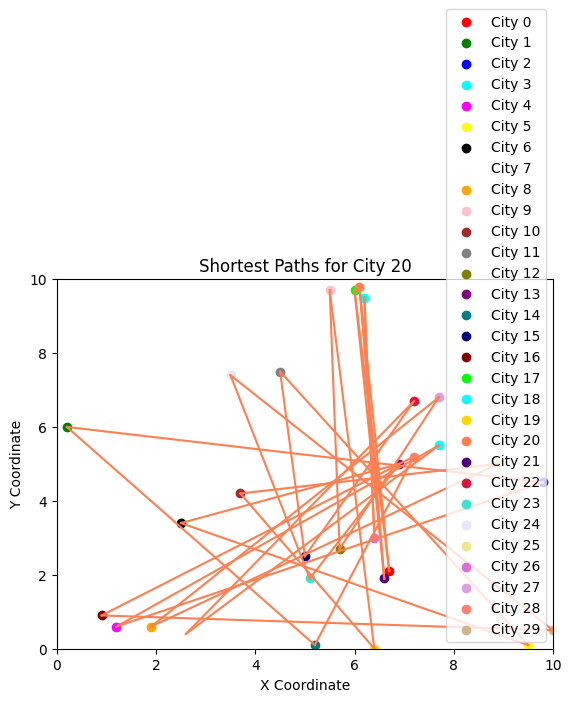

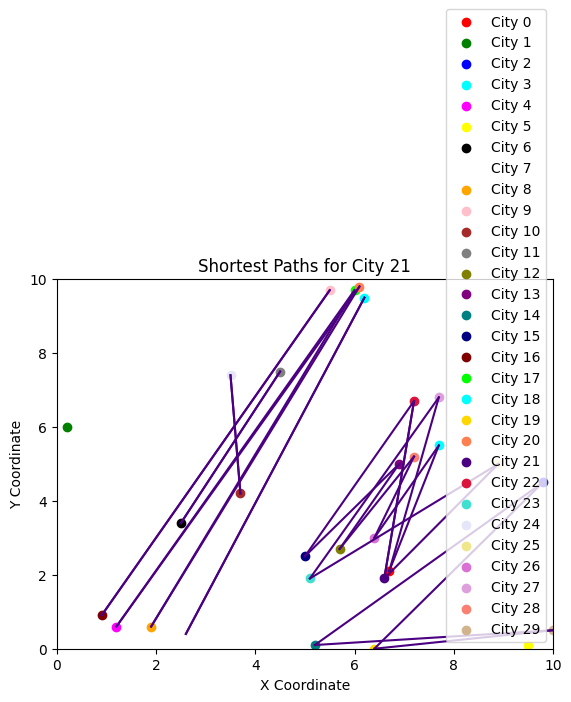

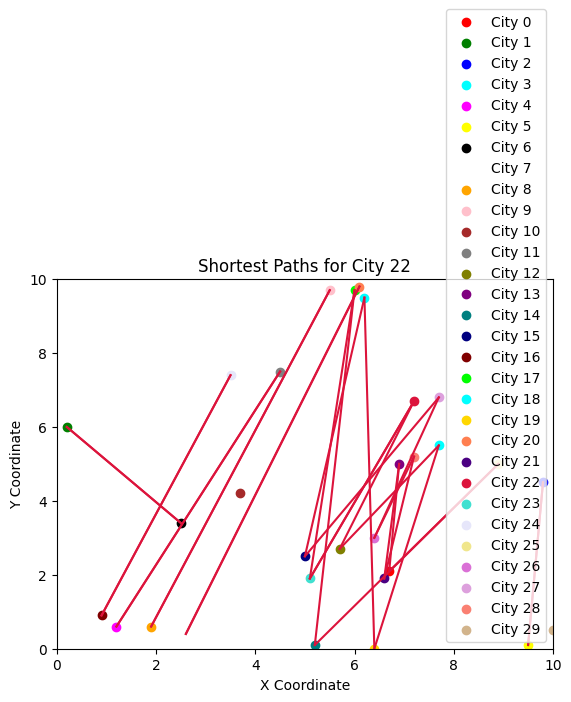

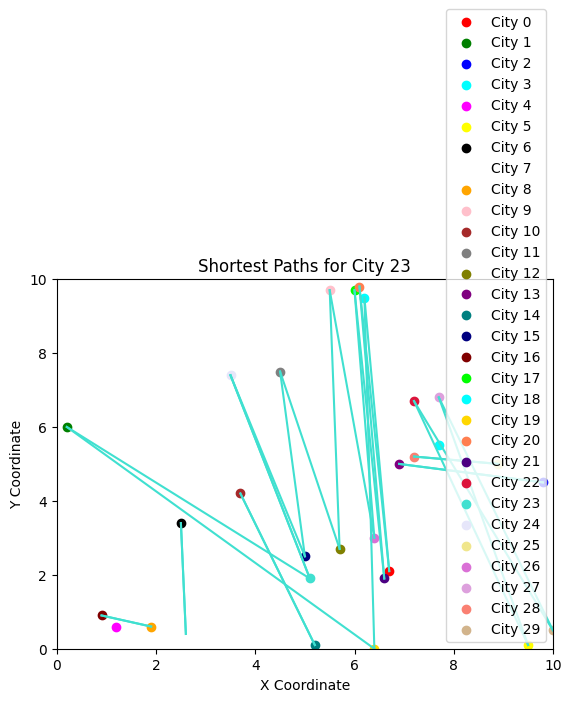

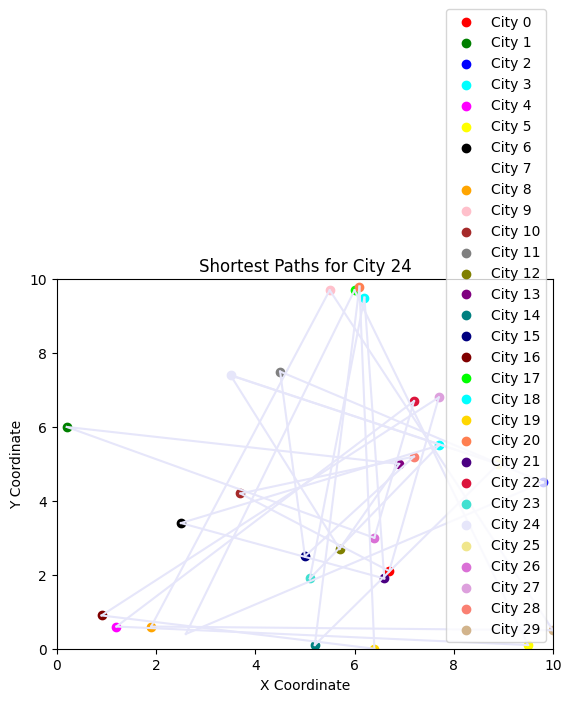

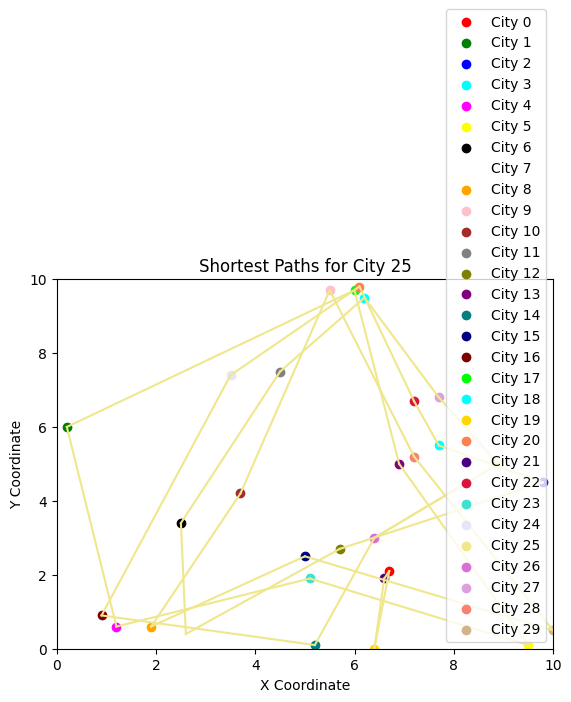

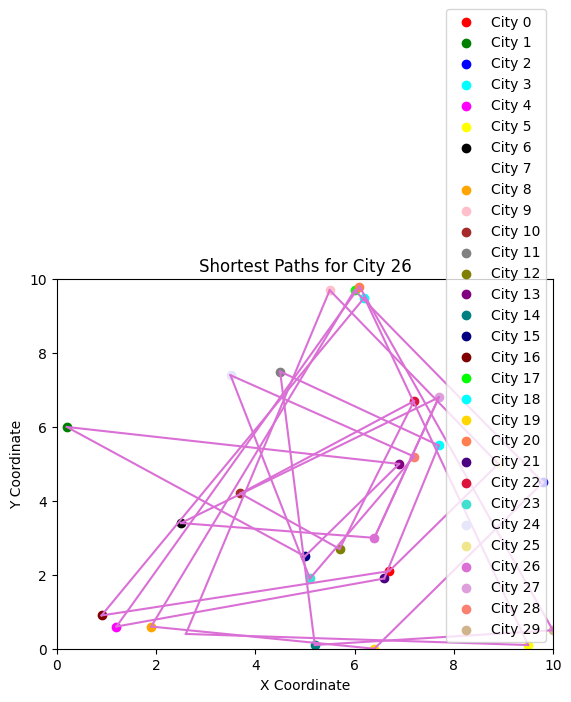

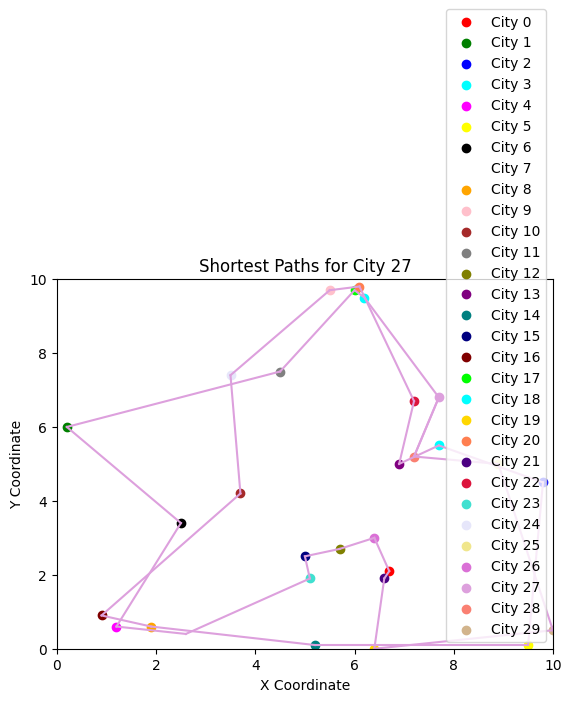

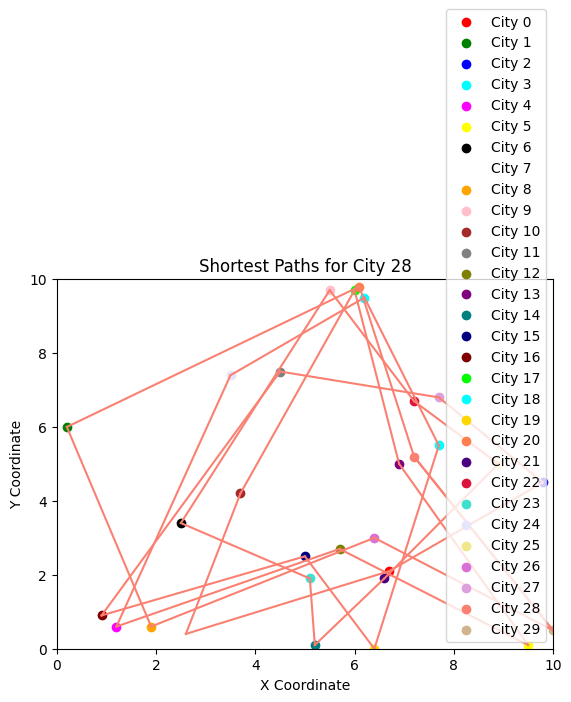

In [172]:
for k in range(n-1):
  fig, ax = plt.subplots()

  colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 
            'white', 'orange', 'pink', 'brown', 'gray', 'olive', 'purple', 
            'teal', 'navy', 'maroon', 'lime', 'aqua', 'gold', 'coral', 'indigo', 
            'crimson', 'turquoise', 'lavender', 'khaki', 'orchid', 'plum', 
            'salmon', 'tan']

  for i in range(n):
    ax.scatter(x[i], y[i], c=colors[i], label=f'City {i}')

  ax.set_xlabel('X Coordinate')
  ax.set_ylabel('Y Coordinate')
  ax.set_title(f'Shortest Paths for City {k}')
  ax.legend()

  start_city = best_tours[k]
  end_city = best_tours[k+1]

  start_x = x[start_city]
  start_y = y[start_city]

  end_x = x[end_city]
  end_y = y[end_city]

  ax.plot([start_x, end_x], [start_y, end_y], color=colors[k])

  plt.xlim(0, 10)
  plt.ylim(0, 10)

  plt.show()